In [1]:
from datetime import datetime as dt
import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from pprint import pprint

In [3]:
sys.path.append('../src/')
import helper

In [4]:
today = dt.today().isoformat().split("T")[0]
today

'2021-12-05'

In [5]:
datapath = '../data/raw/WA_Fn-UseC_-HR-Employee-Attrition.csv'

In [6]:
ibm = pd.read_csv(datapath)

In [7]:
data_loader = helper.IBMData(datapath, verbose=True)
X, y = data_loader.separate_response


Split X and y...
self.X.shape (1470, 34)
self.y.shape (1470,)


In [8]:
data_pp = helper.PreProcess(X, verbose=True)
data_pp.preprocess_data()


The following categorical_columns have been label encoded: ['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']

The following categorical_columns have been binarized: ['Gender', 'Over18', 'OverTime']


In [9]:
preprocessed_X = data_pp.pp_X

preproccessed_X_and_y = pd.concat([preprocessed_X, y], axis=1)
preproccessed_X_and_y.shape

(1470, 35)

In [10]:
std_sc = StandardScaler()

In [11]:
pp_stdsc_X = std_sc.fit_transform(preprocessed_X)
pp_stdsc_X_df = pd.DataFrame(pp_stdsc_X, columns=preprocessed_X.columns)

In [12]:
response_col = 'Attrition'

cat_num_cols = ["Education", "EnvironmentSatisfaction", "JobInvolvement",
                "JobLevel", "JobSatisfaction", "NumCompaniesWorked", "PerformanceRating", 
                "RelationshipSatisfaction", "StockOptionLevel", "TrainingTimesLastYear", "WorkLifeBalance"]

numeric_cols = [col for col in ibm.columns if (type(ibm.loc[0, col]) != str) 
                and (col not in cat_num_cols) 
                and (col != response_col)]

categoricals = [col for col in ibm.columns if (col not in numeric_cols) and 
                (col not in cat_num_cols) and 
                (col != response_col)]

#### Observations
- Certain of the numeric columns look to have uniform distribution 
    - DailyRate
    - Hourly Rate (likely highly colinear & highly correlated to DailyRate
    - Monthly Rate (likely highly colinear & highly correlated to DailyRate)
- Others look to have high skew 
    - Distance from Home
    - Percent Salary Hike
    - Monthly Income
    - Total Working Years
    - Years at Company
    - Years Since Last Promotion
- Bimodal / Multimodal distribution
    - Years in Current Role

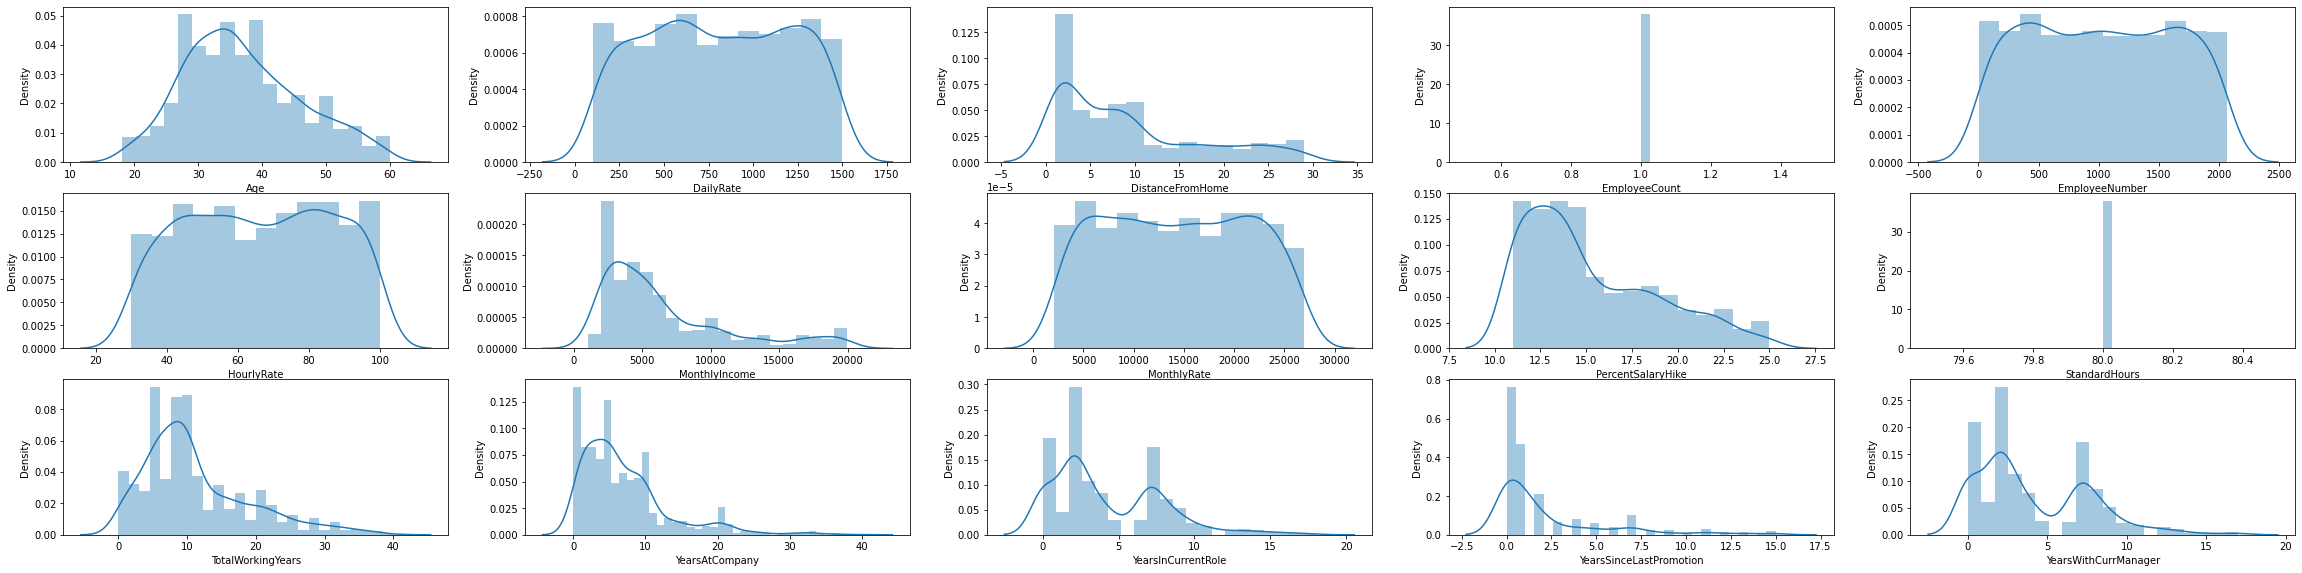

In [13]:
fig = plt.figure(1, figsize=(40, 20))
for i, col in enumerate(numeric_cols):
    fig.add_subplot(6, 5, i + 1)
    sns.distplot(ibm[col].dropna())
plt.show()
fig.savefig(f'../reports/ibm-distplots-{today}.png')

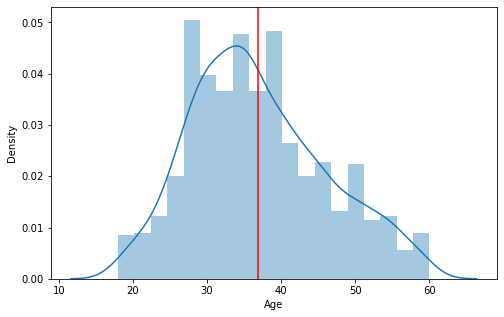

In [14]:
age_fig = plt.figure(1, figsize=(8, 5))
sns.distplot(ibm['Age'])
plt.axvline(ibm['Age'].mean(), color='red')
plt.show()
age_fig.savefig('../reports/figures/age-distribution.png')

In [15]:
import scipy.stats as ss

def plot_exponential(x_range, mu=0, sigma=1, cdf=False, **kwargs):
    '''
    Plots the exponential distribution function for a given x range
    If mu and sigma are not provided, standard exponential is plotted
    If cdf=True cumulative distribution is plotted
    Passes any keyword arguments to matplotlib plot function
    '''
    x = x_range
    if cdf:
        y = ss.expon.cdf(x, mu, sigma)
    else:
        y = ss.expon.pdf(x, mu, sigma)
    plt.plot(x, y, **kwargs)

In [16]:
ibm['DistanceFromHome'].describe()

count    1470.000000
mean        9.192517
std         8.106864
min         1.000000
25%         2.000000
50%         7.000000
75%        14.000000
max        29.000000
Name: DistanceFromHome, dtype: float64

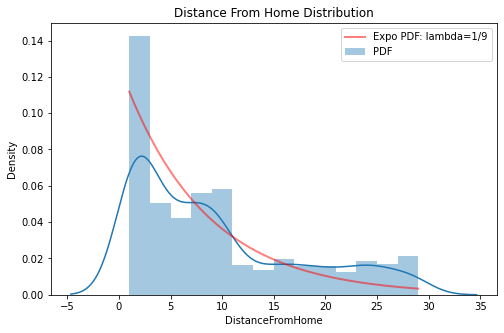

In [17]:
expo_fig = plt.figure(1, figsize=(8, 5))
sns.distplot(ibm['DistanceFromHome'], label='PDF')

x = np.linspace(min(ibm['DistanceFromHome']), max(ibm['DistanceFromHome']), 1000)

plot_exponential(x, 1/9, 8, color='red', lw=2, ls='-', alpha=0.5, label='Expo PDF: lambda=1/9')
plt.legend()
plt.title('Distance From Home Distribution')
plt.show()

expo_fig.savefig('../reports/figures/expo-distributions.png')

#### Hourly Rate

In [18]:
ibm['HourlyRate'].describe()

count    1470.000000
mean       65.891156
std        20.329428
min        30.000000
25%        48.000000
50%        66.000000
75%        83.750000
max       100.000000
Name: HourlyRate, dtype: float64

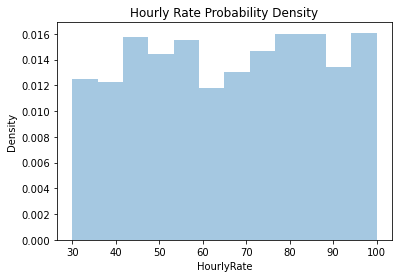

In [19]:
sns.distplot(ibm['HourlyRate'], norm_hist=True, kde=False)
plt.ylabel('Density')
plt.title('Hourly Rate Probability Density')
plt.show()

<AxesSubplot:xlabel='Education', ylabel='HourlyRate'>

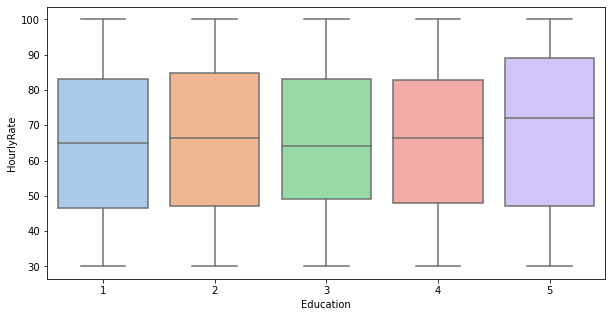

In [20]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='Education', y='HourlyRate', data=ibm, palette='pastel')

#### Age and Education
- create a joint pdf

In [21]:
less_22_edu_total = ibm[(ibm['Age'] >= 18) & (ibm['Age'] < 22)]['Education'].count()

age_18_22 = pd.DataFrame(ibm[(ibm['Age'] >= 18) & (ibm['Age'] < 22)]['Education'].value_counts() / less_22_edu_total).T
age_18_22['total_count'] = less_22_edu_total
age_18_22.reset_index(inplace=True)
age_18_22.rename(columns={'index': 'age_group'}, inplace=True)
age_18_22.index = ['18-22']

In [22]:
less_27_edu_total = ibm[(ibm['Age'] >= 22) & (ibm['Age'] < 27)]['Education'].count()

age_22_27 = pd.DataFrame(ibm[(ibm['Age'] >= 22) & (ibm['Age'] < 27)]['Education'].value_counts() / less_27_edu_total).T
age_22_27['total_count'] = less_27_edu_total
age_22_27.reset_index(inplace=True)
age_22_27.rename(columns={'index': 'age_group'}, inplace=True)
age_22_27.index = ['22-27']
age_22_27

age_group_edu_df = pd.concat([age_18_22, age_22_27])

In [23]:
less_36_edu_total = ibm[(ibm['Age'] >= 27) & (ibm['Age'] < 36)]['Education'].count()

age_27_36 = pd.DataFrame(ibm[(ibm['Age'] >= 27) & (ibm['Age'] < 36)]['Education'].value_counts() / less_36_edu_total).T
age_27_36['total_count'] = less_36_edu_total
age_27_36.reset_index(inplace=True)
age_27_36.rename(columns={'index': 'age_group'}, inplace=True)
age_27_36.index = ['27-36']
age_27_36

age_group_edu_df = pd.concat([age_group_edu_df, age_27_36])

In [24]:
less_45_edu_total = ibm[(ibm['Age'] >= 36) & (ibm['Age'] < 45)]['Education'].count()

age_36_45 = pd.DataFrame(ibm[(ibm['Age'] >= 36) & (ibm['Age'] < 45)]['Education'].value_counts() / less_45_edu_total).T
age_36_45['total_count'] = less_45_edu_total
age_36_45.reset_index(inplace=True)
age_36_45.rename(columns={'index': 'age_group'}, inplace=True)
age_36_45.index = ['36-45']
age_36_45

age_group_edu_df = pd.concat([age_group_edu_df, age_36_45])

In [25]:
less_54_edu_total = ibm[(ibm['Age'] >= 45) & (ibm['Age'] < 54)]['Education'].count()

age_45_54 = pd.DataFrame(ibm[(ibm['Age'] >= 45) & (ibm['Age'] < 54)]['Education'].value_counts() / less_54_edu_total).T
age_45_54['total_count'] = less_54_edu_total
age_45_54.reset_index(inplace=True)
age_45_54.rename(columns={'index': 'age_group'}, inplace=True)
age_45_54.index = ['45-54']
age_45_54

age_group_edu_df = pd.concat([age_group_edu_df, age_45_54])

In [26]:
less_60_edu_total = ibm[(ibm['Age'] >= 54)]['Education'].count()

age_54_60 = pd.DataFrame(ibm[(ibm['Age'] >= 54)]['Education'].value_counts() / less_60_edu_total).T
age_54_60['total_count'] = less_60_edu_total
age_54_60.reset_index(inplace=True)
age_54_60.rename(columns={'index': 'age_group'}, inplace=True)
age_54_60.index = ['54+']
age_54_60

age_group_edu_df = pd.concat([age_group_edu_df, age_54_60])

In [27]:
age_group_edu = age_group_edu_df.drop('age_group', axis=1)[[1, 2, 3, 4, 5, 'total_count']]
age_group_edu['count_pct_of_total'] = age_group_edu['total_count'] / age_group_edu['total_count'].sum()

for c in age_group_edu.columns:
    if type(c) == int:
        age_group_edu[f'{str(c)}_joint_pdf'] = round(age_group_edu[c] * age_group_edu['count_pct_of_total'], 4)
    
age_edu_pdf = age_group_edu[['1_joint_pdf', '2_joint_pdf', '3_joint_pdf', '4_joint_pdf', '5_joint_pdf']]
age_edu_pdf

,1_joint_pdf,2_joint_pdf,3_joint_pdf,4_joint_pdf,5_joint_pdf
18-22,0.0088,0.0054,0.0136,NaN,NaN
22-27,0.0265,0.0204,0.0299,0.0054,NaN
27-36,0.0456,0.0626,0.1578,0.1082,0.0116
36-45,0.0211,0.0612,0.1129,0.0823,0.0129
45-54,0.0095,0.0340,0.0531,0.0524,0.0054
54+,0.0041,0.0082,0.0218,0.0224,0.0027


#### Education & JobRole

<AxesSubplot:>

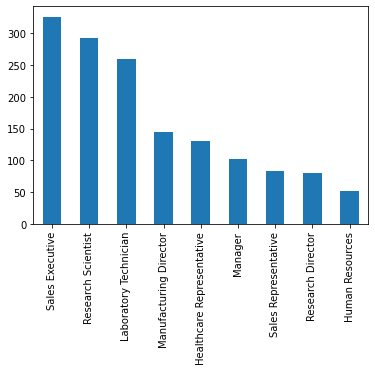

In [28]:
ibm['JobRole'].value_counts().plot(kind='bar')

In [29]:
pd.DataFrame(ibm['JobRole'].value_counts() / 1470)

,JobRole
Sales Executive,0.221769
Research Scientist,0.198639
Laboratory Technician,0.176190
Manufacturing Director,0.098639
Healthcare Representative,0.089116
Manager,0.069388
Sales Representative,0.056463
Research Director,0.054422
Human Resources,0.035374


In [30]:
count_edu_cap_jobrole = pd.pivot_table(ibm, index='Education', columns='JobRole', aggfunc='count')[['Age']]
count_edu_cap_jobrole.reset_index(drop=False, inplace=True)
count_edu_cap_jobrole.columns = count_edu_cap_jobrole.columns.droplevel(0)
count_edu_cap_jobrole.rename(columns={'':'Education'}, inplace=True)
count_edu_cap_jobrole['total_by_edu'] = count_edu_cap_jobrole.sum(axis=1)
display(count_edu_cap_jobrole)
print(count_edu_cap_jobrole.columns)

pct_edu_cap_jobrole = count_edu_cap_jobrole.copy()

for role in ibm['JobRole'].unique().tolist():
    pct_edu_cap_jobrole[f'{role}_pct'] = pct_edu_cap_jobrole[role]/pct_edu_cap_jobrole['total_by_edu']
    
pct_edu_cap_jobrole = pct_edu_cap_jobrole[[c for c in pct_edu_cap_jobrole.columns if 'pct' in c]]
# pct_edu_cap_jobrole['most_likely'] = 

JobRole,Education,Healthcare Representative,Human Resources,Laboratory Technician,Manager,Manufacturing Director,Research Director,Research Scientist,Sales Executive,Sales Representative,total_by_edu
0,1,15.0,5.0,35.0,9.0,15.0,7.0,37.0,27.0,20.0,171.0
1,2,21.0,12.0,57.0,19.0,33.0,13.0,46.0,66.0,15.0,284.0
2,3,48.0,22.0,104.0,40.0,54.0,30.0,122.0,120.0,32.0,575.0
3,4,44.0,10.0,58.0,29.0,38.0,23.0,79.0,101.0,16.0,402.0
4,5,3.0,3.0,5.0,5.0,5.0,7.0,8.0,12.0,NaN,53.0


Index(['Education', 'Healthcare Representative', 'Human Resources',
       'Laboratory Technician', 'Manager', 'Manufacturing Director',
       'Research Director', 'Research Scientist', 'Sales Executive',
       'Sales Representative', 'total_by_edu'],
      dtype='object', name='JobRole')


#### Job Role & Pay
- Irrespective of job role, the average hourly rate is approximately the same across job roles.
- However, the 25th percentile for hourly rate is slightly higher for Managerial positions than for other positions at the company. 
- Because the difference in the 25th and 75h percentiles across job roles are reasonably negligable in terms of absolute dollars and percentages, we need not apply any conditional probability logic here in order to keep the simulation model.

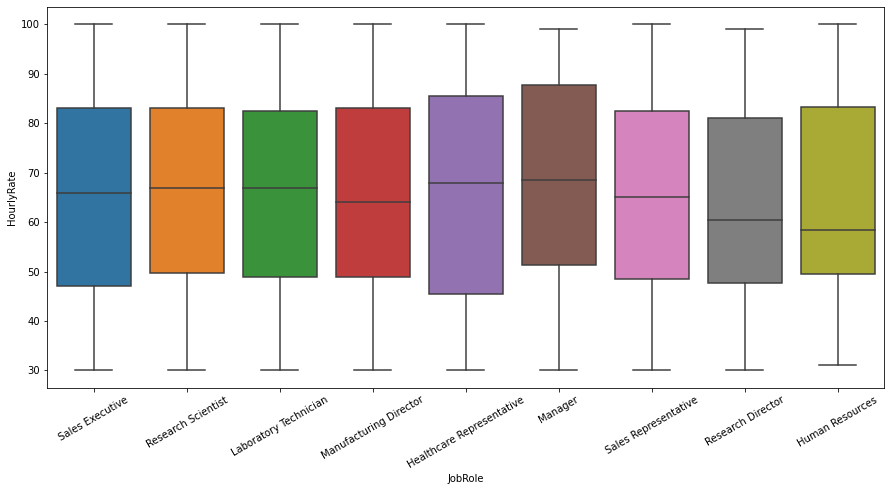

In [31]:
fig_job_hrly = plt.figure(1, figsize=(15, 7))
sns.boxplot(x="JobRole", y="HourlyRate", data=ibm)
plt.xticks(rotation=30)
plt.show()

#### Percent Salary Hike

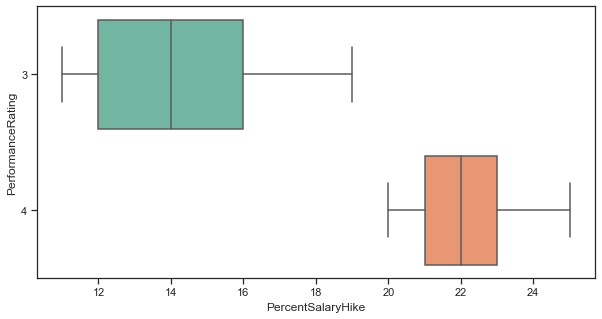

In [32]:
sns.set_theme(style="ticks")

plt.figure(1, figsize=(10, 5))

ax = sns.boxplot(data=ibm, orient="h", x='PercentSalaryHike', y='PerformanceRating', palette="Set2")
plt.show()

In [33]:
min(ibm['PercentSalaryHike'])

11

In [34]:
import scipy.stats as stats
from icecream import ic

In [35]:
salhike_perf3 = ibm[ibm['PerformanceRating'] == 3]['PercentSalaryHike']
display(salhike_perf3.describe())
ic(stats.mode(salhike_perf3))

salhike_perf4 = ibm[ibm['PerformanceRating'] == 4]['PercentSalaryHike']
display(salhike_perf4.describe())
ic(stats.mode(salhike_perf4))

count    1244.000000
mean       14.003215
std         2.434333
min        11.000000
25%        12.000000
50%        14.000000
75%        16.000000
max        19.000000
Name: PercentSalaryHike, dtype: float64

ic| stats.mode(salhike_perf3): ModeResult(mode=array([11]), count=array([210]))


count    226.000000
mean      21.849558
std        1.544719
min       20.000000
25%       21.000000
50%       22.000000
75%       23.000000
max       25.000000
Name: PercentSalaryHike, dtype: float64

ic| stats.mode(salhike_perf4): ModeResult(mode=array([22]), count=array([56]))


ModeResult(mode=array([22]), count=array([56]))

### Observations on Percentage Salary Hike
- they do not follow exponential distributions in the same way that the distance from home did
- instead, it looks like right skew triangular distributions

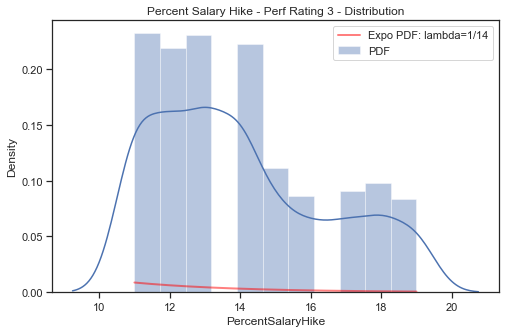

In [36]:
sal_hike_fig3 = plt.figure(1, figsize=(8, 5))
sns.distplot(salhike_perf3, label='PDF', kde=True)

x = np.linspace(min(salhike_perf3), max(salhike_perf3), 1000)
plot_exponential(x, 1/14, 3, color='red', lw=2, ls='-', alpha=0.5, label='Expo PDF: lambda=1/14')

plt.legend()
plt.title('Percent Salary Hike - Perf Rating 3 - Distribution')
plt.show()

# sal_hike_fig3.savefig('../reports/figures/salhike-perfrating3-distribution.png')

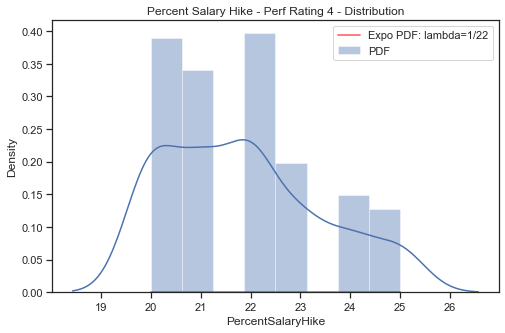

In [37]:
sal_hike_fig4 = plt.figure(1, figsize=(8, 5))
sns.distplot(salhike_perf4, label='PDF', kde=True)

x = np.linspace(min(salhike_perf4), max(salhike_perf4), 1000)
plot_exponential(x, 1/22, 2, color='red', lw=2, ls='-', alpha=0.5, label='Expo PDF: lambda=1/22')

plt.legend()
plt.title('Percent Salary Hike - Perf Rating 4 - Distribution')
plt.show()

# sal_hike_fig3.savefig('../reports/figures/salhike-perfrating4-distribution.png')

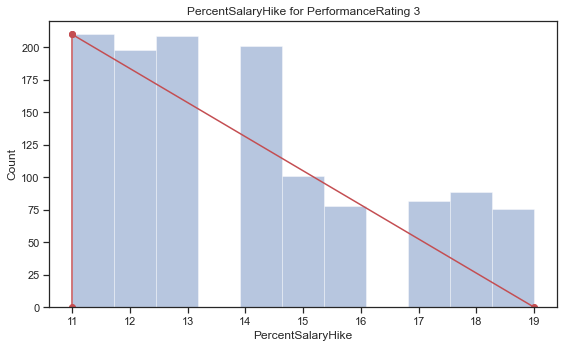

In [38]:
pct_sal_hike_3 = plt.figure(1, figsize=(8, 5))

x1, y1 = [[11,11], [0, salhike_perf3.value_counts()[11]]]
x2, y2 = [[11, 19], [salhike_perf3.value_counts()[11], 0]]
plt.plot(x1, y1, x2, y2, marker = 'o', c='r')

sns.distplot(salhike_perf3, kde=False)

plt.ylabel('Count')
plt.title('PercentSalaryHike for PerformanceRating 3')
plt.tight_layout()
plt.show()

pct_sal_hike_3.savefig('../reports/figures/pctsalhike-perf3-tria-distribution.png')

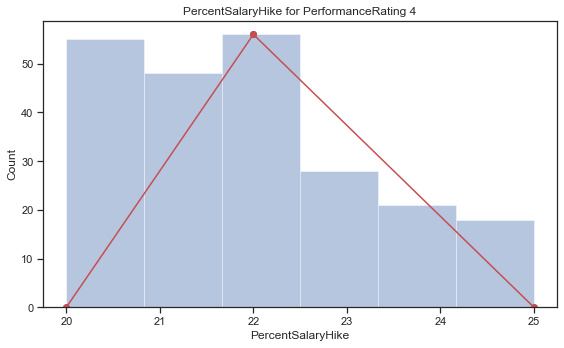

In [39]:
pct_sal_hike_4 = plt.figure(1, figsize=(8, 5))

x1, y1 = [[20,22], [0, salhike_perf4.value_counts()[22]]]
x2, y2 = [[22, 25], [salhike_perf4.value_counts()[22], 0]]
plt.plot(x1, y1, x2, y2, marker = 'o', c='r')

sns.distplot(salhike_perf4, kde=False, bins=6)

plt.ylabel('Count')
plt.title('PercentSalaryHike for PerformanceRating 4')
plt.tight_layout()
plt.show()

pct_sal_hike_4.savefig('../reports/figures/pctsalhike-perf4-tria-distribution.png')

#### Correlation Analysis for Collinearity
- Interesting that the daily, hourly, and monthly rates do not have strong coorelation with one another (as one would have suspected previously)

In [40]:
corr = preproccessed_X_and_y.corr()

In [41]:
collinear_pairs = list()

for i, row in corr.iterrows():
    corr_cols = (np.where(row > 0.6))[0]
    pair = set()
    for j in corr_cols:
        if corr.loc[i, corr.columns[j]] != 1: 
            pair = set([i, corr.columns[j]])
            if pair not in collinear_pairs:
                collinear_pairs.append(pair) 

pprint(collinear_pairs)

[{'TotalWorkingYears', 'Age'},
 {'Department', 'JobRole'},
 {'MonthlyIncome', 'JobLevel'},
 {'TotalWorkingYears', 'JobLevel'},
 {'MonthlyIncome', 'TotalWorkingYears'},
 {'PerformanceRating', 'PercentSalaryHike'},
 {'TotalWorkingYears', 'YearsAtCompany'},
 {'YearsInCurrentRole', 'YearsAtCompany'},
 {'YearsAtCompany', 'YearsSinceLastPromotion'},
 {'YearsWithCurrManager', 'YearsAtCompany'},
 {'YearsInCurrentRole', 'YearsWithCurrManager'}]


In [42]:
ibm[['DailyRate', 'HourlyRate', 'MonthlyRate', 'MonthlyIncome']].sample(7)

,DailyRate,HourlyRate,MonthlyRate,MonthlyIncome
876,654,43,5050,2678
486,558,75,3010,9602
1451,345,100,5982,5343
8,216,44,8787,9526
655,1075,57,22650,2277
583,1111,93,13305,6500
285,1372,42,15881,2115


#### Educational Impact

In [43]:
edu_levels = ibm['Education'].value_counts()

In [44]:
ibm['JobRole'].value_counts()

Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sales Representative          83
Research Director             80
Human Resources               52
Name: JobRole, dtype: int64

In [45]:
edu_fields = ibm['EducationField'].unique().tolist()
job_roles = ibm['JobRole'].unique().tolist()
depts = ibm['Department'].unique().tolist()
edu_levels = ibm['Education'].unique().tolist()

edu_level_map = dict(zip([1, 2, 3, 4, 5], ['Below College', 'College', 'Bachelor', 'Master', 'Doctor']))
edu_level_map

{1: 'Below College', 2: 'College', 3: 'Bachelor', 4: 'Master', 5: 'Doctor'}

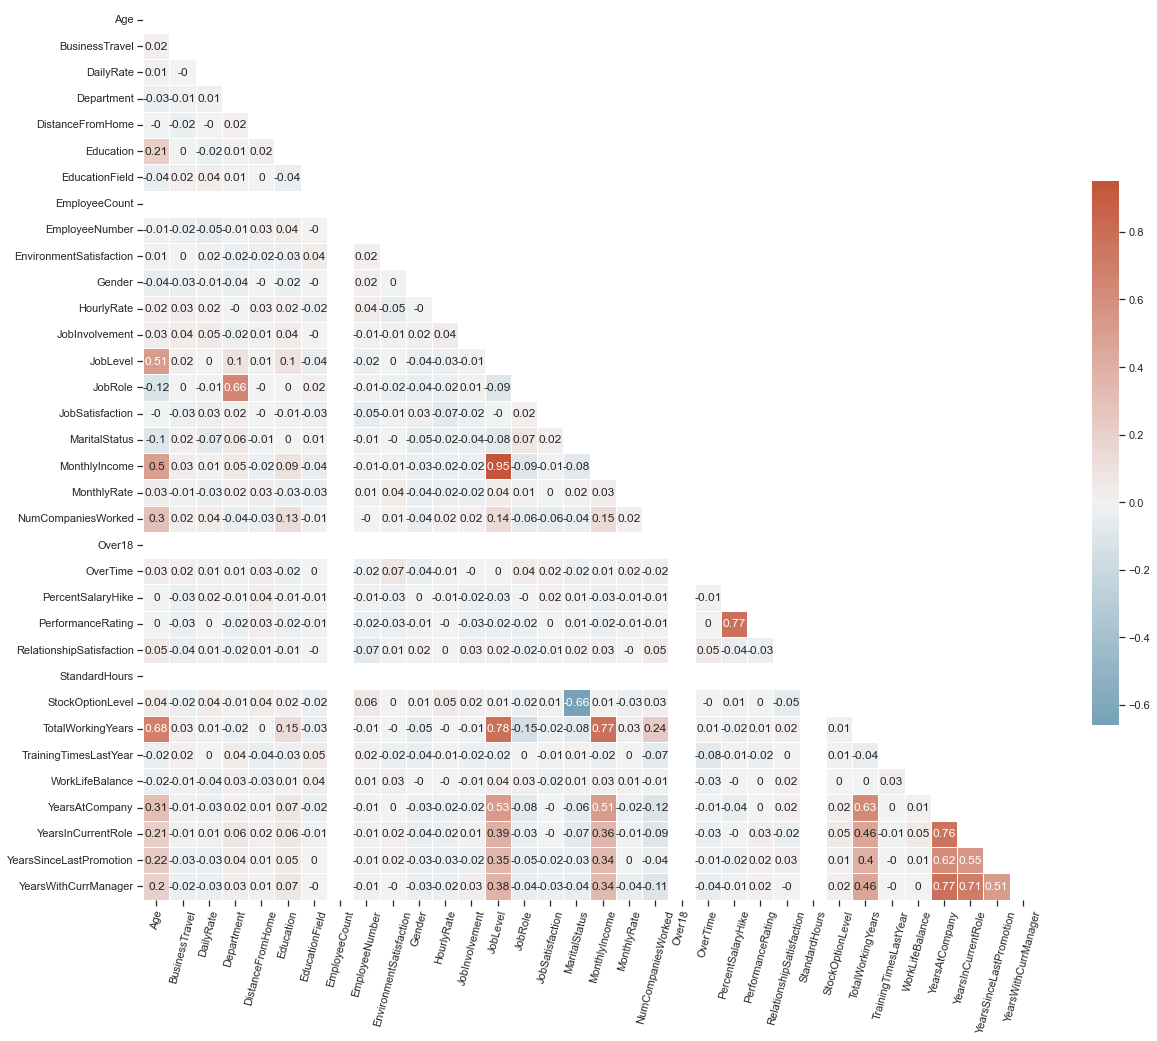

In [46]:
fig2 = plt.figure(1, figsize=(20, 20))

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr.round(2),
            cbar=True,
            mask=mask,
            annot=True,
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5},
            cmap=sns.diverging_palette(230, 20, as_cmap=True))
plt.xticks(rotation=75)
plt.show()
fig2.savefig('../reports/figures/corr-heatmap-annot.png')

#### VIF (Variable Inflation Factor) to Measure Multilinearity
- Reference: https://towardsdatascience.com/statistics-in-python-collinearity-and-multicollinearity-4cc4dcd82b3f


**Observations**
- Employee Count is not a relevant feature as shown in the Correlation heatmap as well as the VIF table below.
- Over 18 is not a valuable attribute either 
- Standard hours is 

In [47]:
def calculate_vif(df, features):    
    vif, tolerance = {}, {}
    
    # all the features that you want to examine
    for feature in features:
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)                
        
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        vif[feature] = 1/(tolerance[feature])
    # return VIF DataFrame
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})


In [48]:
vif_df = calculate_vif(preproccessed_X_and_y, preprocessed_X.columns)
multilin_feats = vif_df[vif_df['VIF'] > 10]
multilin_feats.index.tolist()

['EmployeeCount', 'JobLevel', 'MonthlyIncome', 'Over18', 'StandardHours']

### Observations
- There are categorical attributes that are numerically represented, such as: 
    - Education: 1, 2, 3, 4, 5
    - Environment Satisfaction: 1, 2, 3, 4
    - Job Involvement: 1, 2, 3, 4
    - Job Level: 1, 2, 3, 4, 5
    - Job Satisfaction: 1, 2, 3, 4
    - Num Companies Worked: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
    - Performance Rating: 3, 4
    - Relationship Satisfaction: 1, 2, 3, 4
    - Stock Option Level: 0, 1, 2, 3
    - Training Times Last Year: 0, 1, 2, 3, 4, 5, 6
    - Work Life balance: 1, 2, 3, 4

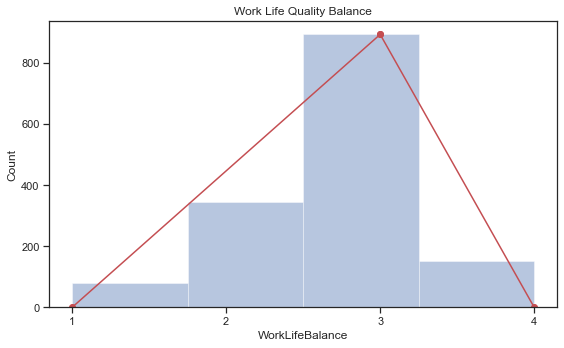

In [49]:
wlb_fig = plt.figure(1, figsize=(8, 5))


x1, y1 = [[1,3], [0, ibm['WorkLifeBalance'].value_counts().max()]]
x2, y2 = [[3, 4], [ibm['WorkLifeBalance'].value_counts().max(),0]]
plt.plot(x1, y1, x2, y2, marker = 'o', c='r')

sns.distplot(ibm['WorkLifeBalance'], kde=False, bins=4)

plt.ylabel('Count')
plt.title('Work Life Quality Balance')
plt.xticks([1, 2, 3, 4])
plt.tight_layout()
plt.show()

wlb_fig.savefig('../reports/figures/worklifebal-tria-distribution.png')

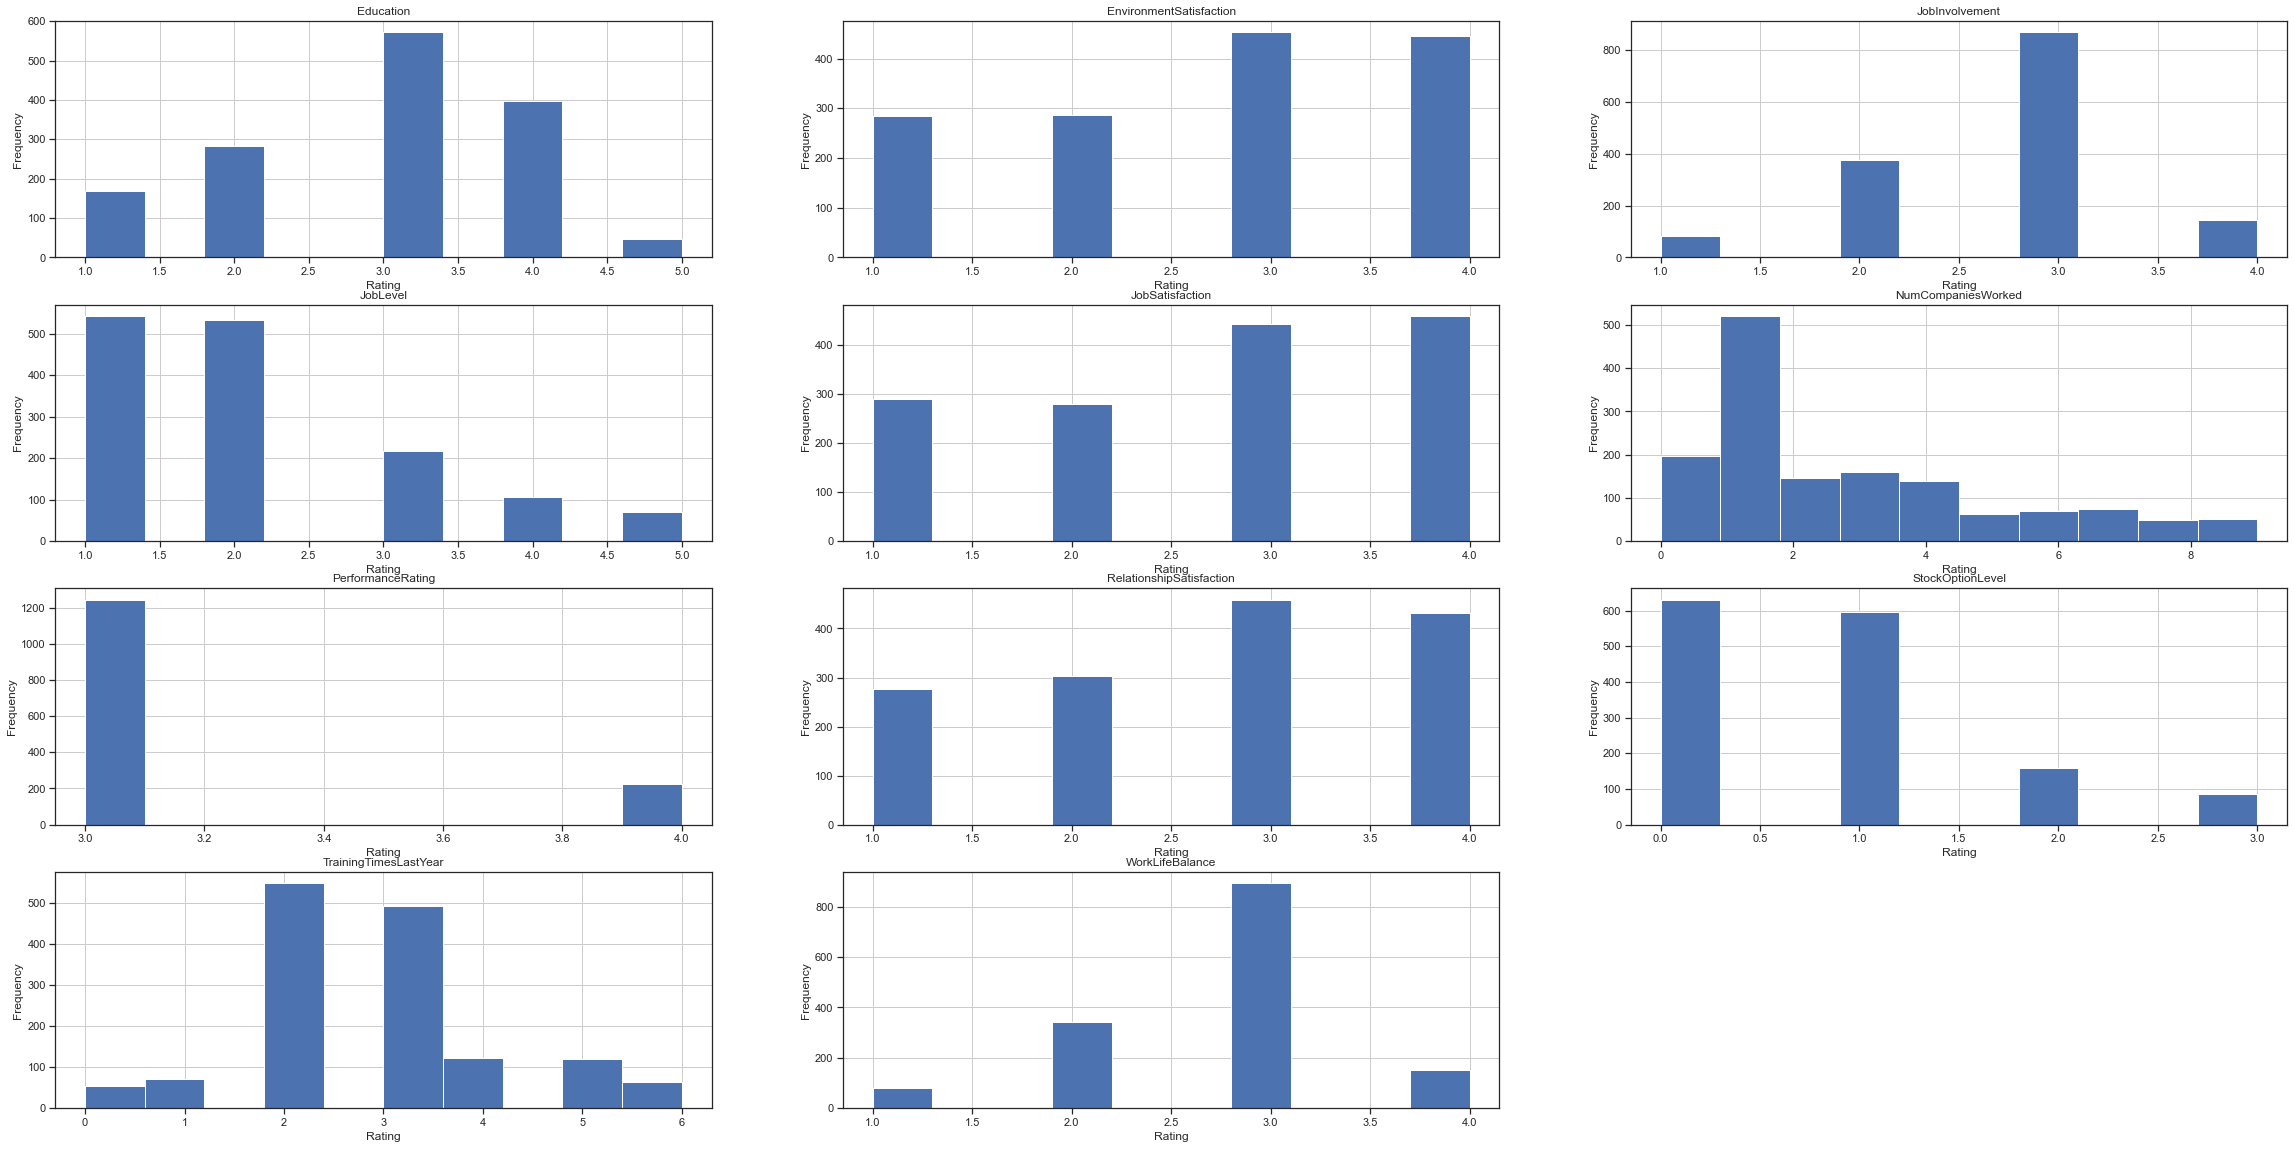

In [50]:
fig = plt.figure(1, figsize=(40, 20))
for i, col in enumerate(cat_num_cols):
    fig.add_subplot(4, 3, i+1)
    ibm[col].hist()
    plt.title(col)
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
plt.show()
fig.savefig(f'../reports/ibm-numeric-categories-{today}.png')

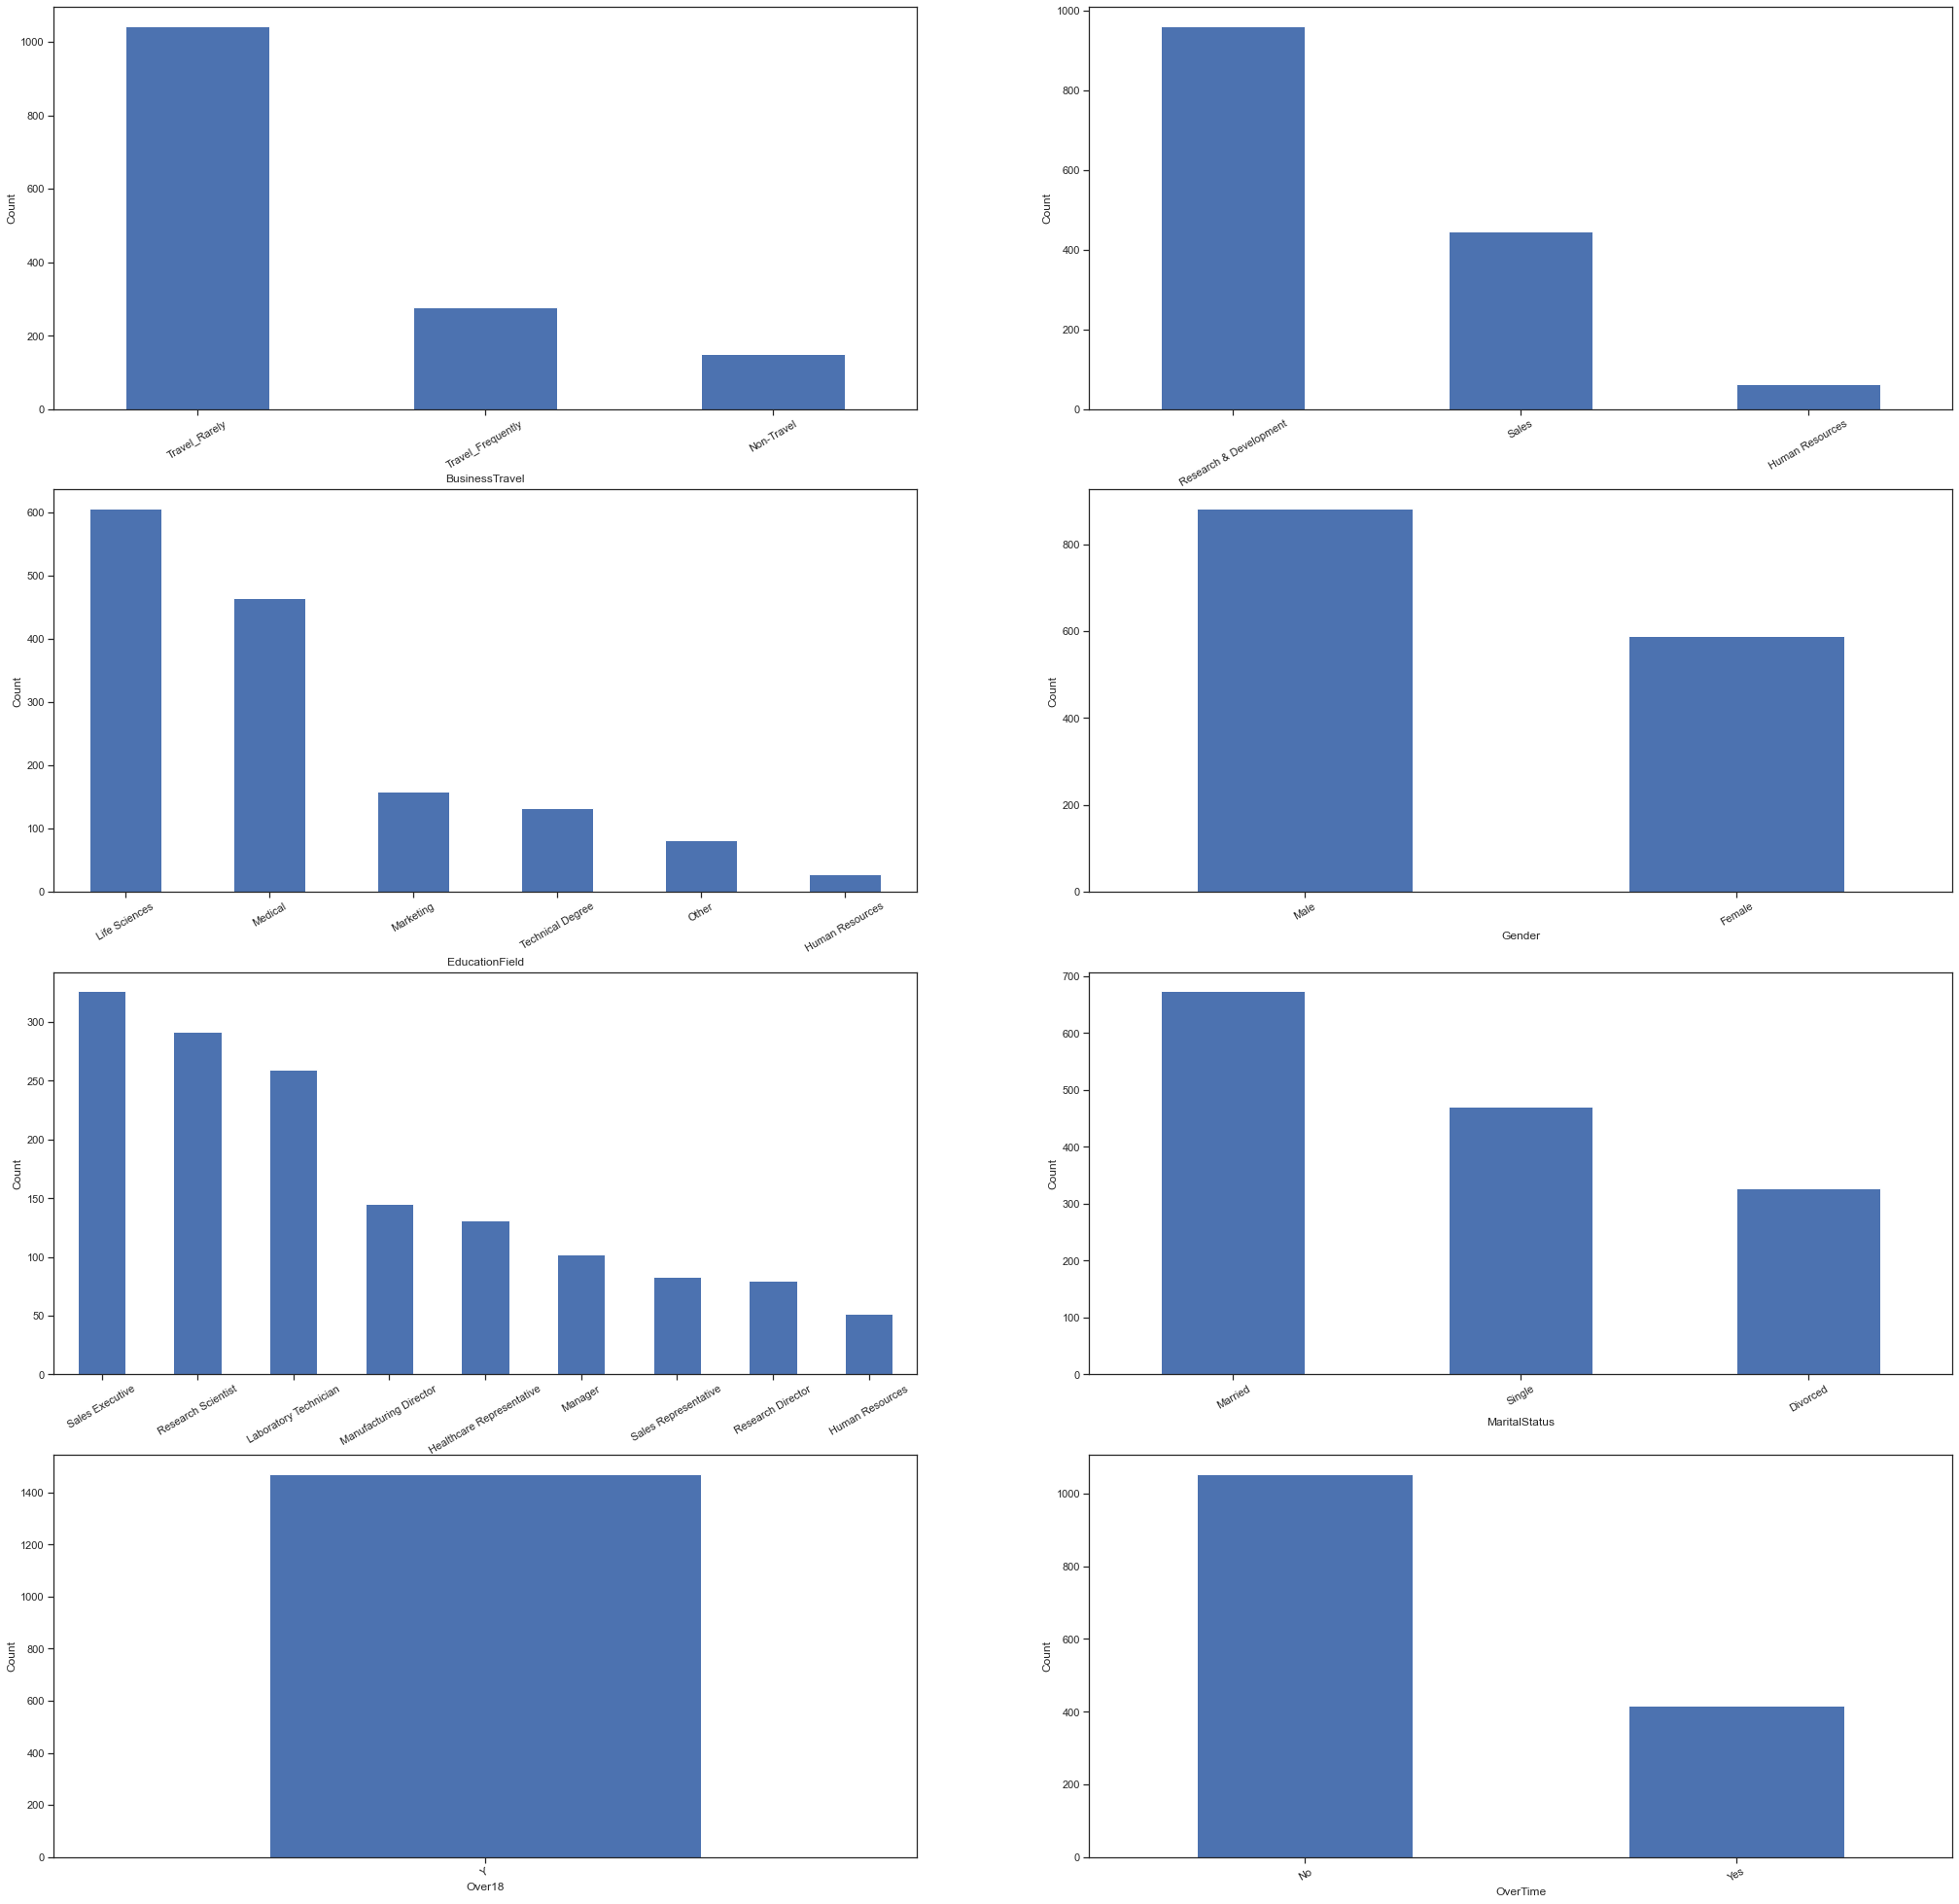

In [51]:
fig = plt.figure(1, figsize=(35, 35))
for i, col in enumerate(categoricals): 
    fig.add_subplot(4, 2, i+1)
    ibm[col].value_counts().plot(kind='bar')
    plt.xticks(rotation=30)
    plt.ylabel('Count')
    plt.xlabel(col)
plt.show()
fig.savefig(f'../reports/ibm-categorical-histograms-{today}.png')